# Web Scraping Project

## Step 1: Install dependencies

Make sure you have the Python packages `pandas` and `requests` installed to work on the project.  
If you don't have these libraries installed, run the following in the console:

```bash
pip install pandas requests lxml
```

In [1]:
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from bs4 import BeautifulSoup



## Step 2: Download HTML

The web page we want to scrape is:  
[https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_the_United_States](https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_the_United_States)

In [2]:
#step 2
url = "https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_the_United_States"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("Starting web scraping")

try:
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        print(f"Success! Downloaded {len(response.text):,} characters of HTML")
        html_content = response.text
        print(html_content[:500] + "...")
    else:
        print(f"Error: HTTP Status {response.status_code}")
except requests.exceptions.RequestException as e:
    print(f"Network error: {e}")

Starting web scraping
Success! Downloaded 916,074 characters of HTML
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vect...


## Step 3: Transform the HTML

Using `BeautifulSoup`, analyze the HTML to find the structure containing the data (e.g., `<table>`, `<li>`, `<div>`, etc.).

In [3]:
print("Starting with beautiful soup")

soup = BeautifulSoup(html_content, 'html.parser')

print("HTML parsed successfully!")
print(f"Page title: {soup.title.string}")  

Starting with beautiful soup
HTML parsed successfully!
Page title: List of tallest buildings in the United States - Wikipedia


## Step 4: Process the DataFrame

Next, clean the rows to obtain clean values by removing `$` and `B`. Also, remove any rows that are empty or lack information.

In [4]:
'''tables = soup.find_all('table', class_='wikitable')
if tables:  
    df = pd.read_html(str(tables[0]))[0]
    df = df.replace(['', '-', 'N/A', 'n/a', 'None', '—'], pd.NA)
    df = df.dropna(how='all').reset_index(drop=True)
    cleaned_df = df.copy()
    print("Table extracted and cleaned.")
    print(cleaned_df.head())
else:
    print("No table found.")
    cleaned_df = pd.DataFrame()'''

tables = soup.find_all('table', class_='wikitable')
if tables:  
    table = tables[0]
    rows = table.find_all('tr')
    data = []

    for row in rows:
        cols = row.find_all(['th', 'td'])
        cols_text = [col.get_text(strip=True) for col in cols]
        data.append(cols_text)

    df = pd.DataFrame(data[1:], columns=data[0])

    df = df.replace(['', '-', 'N/A', 'n/a', 'None', '—'], pd.NA)
    df = df.dropna(how='all').reset_index(drop=True)
    cleaned_df = df.copy()

    print("Table extracted and cleaned.")
    print(cleaned_df.head())
else:
    print("No table found.")
    cleaned_df = pd.DataFrame()

Table extracted and cleaned.
                     Name Image  \
0  One World Trade Center  <NA>   
1      Central Park Tower  <NA>   
2           Willis Tower†  <NA>   
3    111 West 57th Street  <NA>   
4          One Vanderbilt  <NA>   

                                            Location      Heightft (m)  \
0  New York City40°42′46.45″N74°0′47.53″W﻿ / ﻿40....  1,776 ft (541 m)   
1  New York City40°45′59″N73°58′52″W﻿ / ﻿40.7663°...  1,550 ft (472 m)   
2  Chicago41°52′43.82″N87°38′9.73″W﻿ / ﻿41.878838...  1,450 ft (442 m)   
3  New York City40°45′52″N73°58′40″W﻿ / ﻿40.76455...  1,428 ft (435 m)   
4  New York City40°45′11″N73°58′43″W﻿ / ﻿40.7530°...  1,401 ft (427 m)   

                      Floors      Year  \
0  104 (numbered)94 (actual)      2014   
1                         98      2020   
2                        108      1974   
3                         84  2021[14]   
4                         93  2020[17]   

                                               Notes  
0  On M

## Step 5: Store the data in SQLite

Create an empty database instance and include the cleaned data in it.

1. Create the table.
2. Insert the values.
3. Commit the changes.

In [5]:
# Step 5: Store the data in SQLite

if not cleaned_df.empty:
    conn = sqlite3.connect('tallest_buildings_data.db')
    cleaned_df.to_sql('buildings_data', conn, if_exists='replace', index=False)
    print("Data saved to SQLite database.")
    conn.close()
else:
    print("No data available for database storage")

Data saved to SQLite database.


## Step 6: Visualize the data (optional, but highly recommended)

What types of visualizations can we make? Suggest at least 3 and plot them.

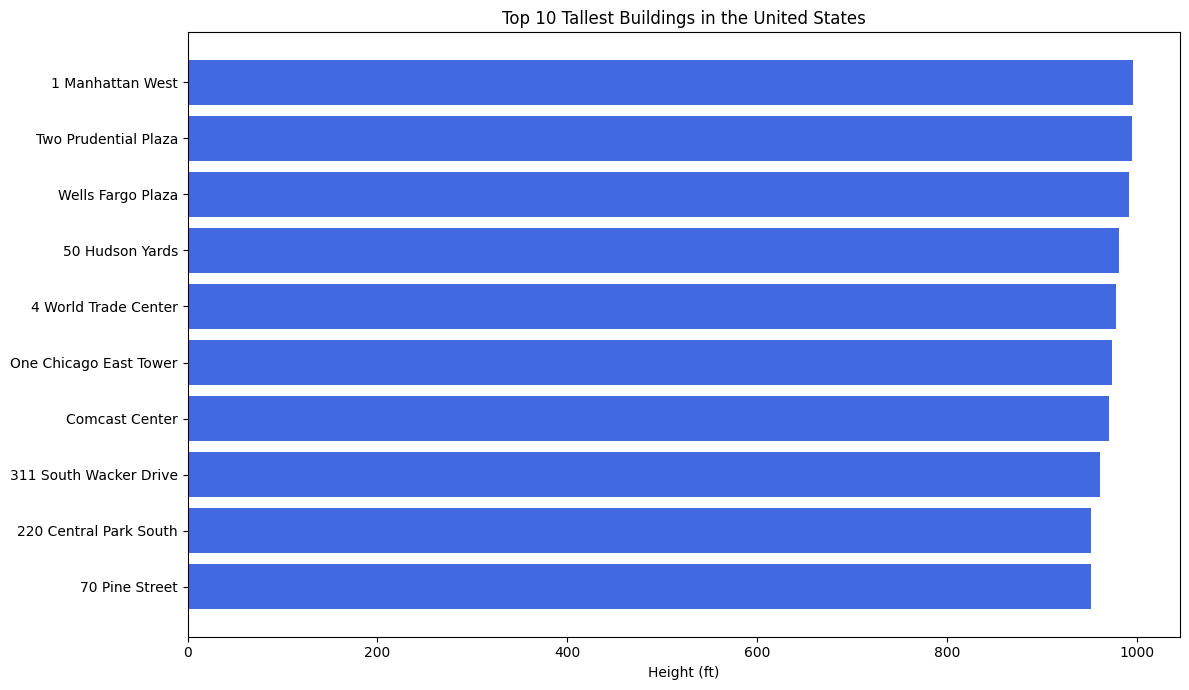

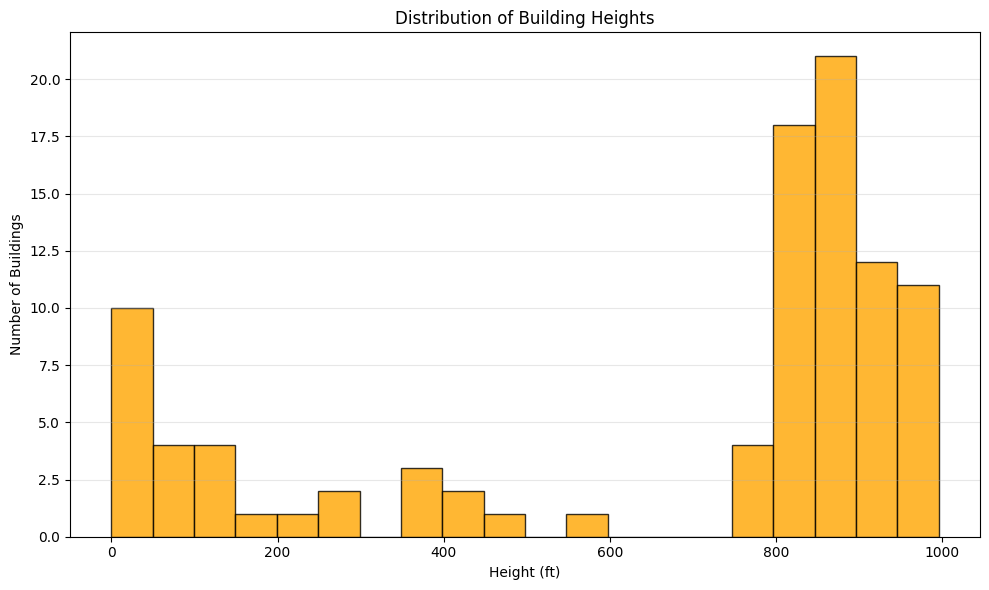

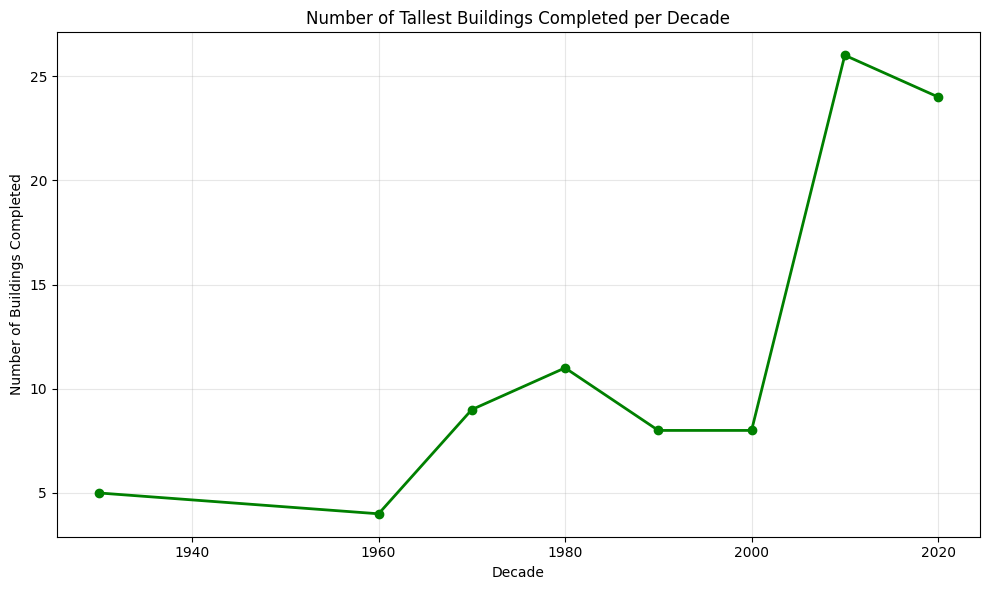


Web scraping project completed successfully.


In [6]:
# Step 6: Creating data visualizations

if not cleaned_df.empty:
    columns = [col.lower() for col in cleaned_df.columns]
    name_col = next((col for col in cleaned_df.columns if 'name' in col.lower()), None)
    city_col = next((col for col in cleaned_df.columns if 'city' in col.lower()), None)
    height_col = next((col for col in cleaned_df.columns if 'height' in col.lower()), None)
    year_col = next((col for col in cleaned_df.columns if 'year' in col.lower()), None)
    floors_col = next((col for col in cleaned_df.columns if 'floor' in col.lower()), None)

    # 1. Top 10 tallest buildings (bar plot)
    if name_col and height_col:
        heights = cleaned_df[height_col].astype(str).str.extract(r'(\d{3,4})', expand=False)
        heights = pd.to_numeric(heights, errors='coerce')
        top10 = cleaned_df.copy()
        top10['height_ft'] = heights
        top10 = top10.dropna(subset=['height_ft'])
        top10 = top10.sort_values('height_ft', ascending=False).head(10)
        plt.figure(figsize=(12, 7))
        plt.barh(top10[name_col][::-1], top10['height_ft'][::-1], color='royalblue')
        plt.xlabel('Height (ft)')
        plt.title('Top 10 Tallest Buildings in the United States')
        plt.tight_layout()
        plt.show()

    # 2. Distribution of building heights (histogram)
    if height_col:
        heights = cleaned_df[height_col].astype(str).str.extract(r'(\d{3,4})', expand=False)
        heights = pd.to_numeric(heights, errors='coerce').dropna()
        plt.figure(figsize=(10, 6))
        plt.hist(heights, bins=20, color='orange', edgecolor='black', alpha=0.8)
        plt.xlabel('Height (ft)')
        plt.ylabel('Number of Buildings')
        plt.title('Distribution of Building Heights')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 3. Number of buildings completed per decade (line plot)
    if year_col:
        years = cleaned_df[year_col].astype(str).str.extract(r'(\d{4})', expand=False)
        years = pd.to_numeric(years, errors='coerce').dropna()
        decades = (years // 10) * 10
        decade_counts = decades.value_counts().sort_index()
        plt.figure(figsize=(10, 6))
        plt.plot(decade_counts.index, decade_counts.values, marker='o', linewidth=2, color='green')
        plt.xlabel('Decade')
        plt.ylabel('Number of Buildings Completed')
        plt.title('Number of Tallest Buildings Completed per Decade')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No data available for visualization")

print("\nWeb scraping project completed successfully.")
